### kaggleのカーネル　よりRES_netとVGGを転移学習で実行

### コンペ内容

## Model architecture tuning & score optimization


Some ideas and code taken from ealier [kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras) and last prepared notebook.

Having dealt with data processing & engineering of channel features, next step of modeling is preparation and tuning of model architecture. Earlier notebooks provided a way to create images with three channels, which will facilitate usage of pretrained models.

For segmentation tasks, a pretrained model can be used as encoder part of the final architecture. 
In order to use pretrained models, we will have to extract features from a few intermediate layers, which will then serve as a basis for layers coming afterwards and for skip connections between encoder and decoder part.

ResNet50 is a good starting point, because it consists of 4 blocks, where each one of them can serve as feature extractor with first layer serving as the 5th extractor to achieve consistency with standard UNet architecture.

石油やガスが大量に蓄積されている地球のいくつかの地域には、地表の下に巨大な塩が堆積しています。

しかし、残念ながら、大規模な塩の堆積物がどこにあるのかを正確に知ることは非常に困難です。専門的な地震イメージングでは、専門家による塩田の解釈を必要とします。これは、非常に主観的で、非常に可変性の高いレンダリングにつながります。さらに憂慮すべきことに、石油・ガス会社の掘削業者にとって危険な状況になる可能性があります。

最も正確な地震画像と3Dレンダリングを作成するために、TGS（世界有数の地球科学データ会社）は、Kaggleの機械学習コミュニティが、地下のターゲットが塩分かどうかを自動的かつ正確に識別するアルゴリズムを構築できるようになることを期待しています。

In [4]:
# !pip install openCV

In [5]:
# !pip install tqdm

In [1]:
import tensorflow as tf

In [11]:
tf.__version__

'1.15.0'

In [3]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [6]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [7]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

### Data loading & depth merge:

In [8]:
train = pd.read_csv('../Sprint18/tgs-salt-identification-challenge/competition_data/train.csv')
test = pd.read_csv('../Sprint18/tgs-salt-identification-challenge/competition_data/sample_submission.csv')
depth = pd.read_csv('../Sprint18/tgs-salt-identification-challenge/competition_data/depths.csv')

train_src = '../Sprint18/tgs-salt-identification-challenge/competition_data/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1  3cb59a4fdc                                             1 5656
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3  c78c89577c                                              101 1
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...

test:
           id rle_mask
0  3e06571ef3      1 1
1  a51b08d882      1 1
2  c32590b06f      1 1
3  15f7a047c7      1 1
4  e8827bc832      1 1

           id                                           rle_mask    z
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...  312
1  3cb59a4fdc                                             1 5656  603
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...  687
3  c78c89577c                                              101 1  236
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...  805


In [9]:
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/sample_submission.csv')
# depth = pd.read_csv('../input/depths.csv')

# train_src = '../input/train/'

# print('train:\n{}'.format(train.head()))
# print('\ntest:\n{}'.format(test.head()))


# train = train.merge(depth, how='left', on='id')
# test = test.merge(depth, how='left', on='id')

# print('\n{}'.format(train.head()))

### Load images and masks, examine random sample:

In [10]:
# トレイン画像データを読み込んでarray化
X_train = np.asarray(
    [cv2.imread(train_src + 'images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread(train_src + 'masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


In [9]:
# X_train = np.asarray(
#     [cv2.imread('../input/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
#     dtype=np.uint8) / 255.
# y_train = np.asarray(
#     [cv2.imread('../input/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
#     dtype=np.uint8) / 255.

# print(X_train.shape, y_train.shape)

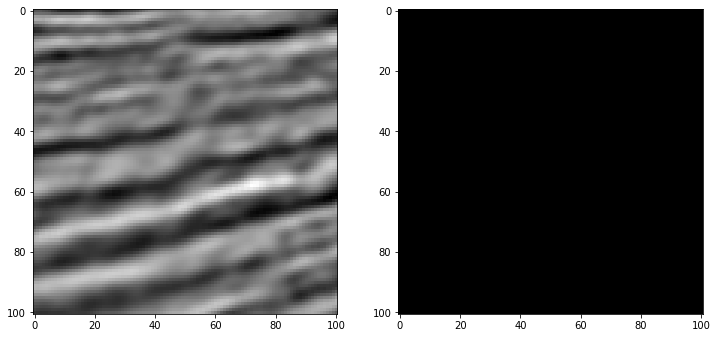

In [15]:
# トレインデータからランダムで適当に表示
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

### Compute salt coverage (this will serve as a basis for stratified split):

In [16]:
train = compute_coverage(train, y_train)

### Prepare data for training:

In [17]:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/opt/anaconda3/envs/sprint13/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


40

### Loss functions & metric:

In [18]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers.
Default input size will be assumed, which is (224, 224, 3).
Layers will be as follows:

- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`.

### Res_netの構成確認(エンコーダ部のみ）

In [19]:
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/opt/anaconda3/envs/sprint13/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Decoder blocks:

Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed.
For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

In [20]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### Model definition:

Combine encoder and decoder blocks to create final segmentation model.

# RES_net

In [21]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('activation_1').output
    encoder2 = base_model.get_layer('activation_10').output
    encoder3 = base_model.get_layer('activation_22').output
    encoder4 = base_model.get_layer('activation_40').output
    encoder5 = base_model.get_layer('activation_49').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Inspect created model:

In [22]:
input_size = (224, 224, 3)


K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

### Train model:

In [23]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 2  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________


Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 11119s 3s/step - loss: 0.7238 - my_iou_metric: 0.3617 - val_loss: 4.2232 - val_my_iou_metric: 0.0058

Epoch 00001: val_my_iou_metric improved from -inf to 0.00575, saving model to unet_resnet.h5
Epoch 2/2
3200/3200 [==============================] - 16387s 5s/step - loss: 0.5468 - my_iou_metric: 0.5114 - val_loss: 2.2336 - val_my_iou_metric: 0.2649

Epoch 00002: val_my_iou_metric improved from 0.00575 to 0.26487, saving model to unet_resnet.h5


### Validation set prediction and resizing to original size:

In [24]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization: 

In [25]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [26]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:55<00:00,  1.58s/it]


In [27]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.3949 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.310279
std,0.204939,0.107305
min,0.200000,0.024250
25%,0.370000,0.318375
50%,0.540000,0.355250
75%,0.710000,0.371500
max,0.880000,0.394875


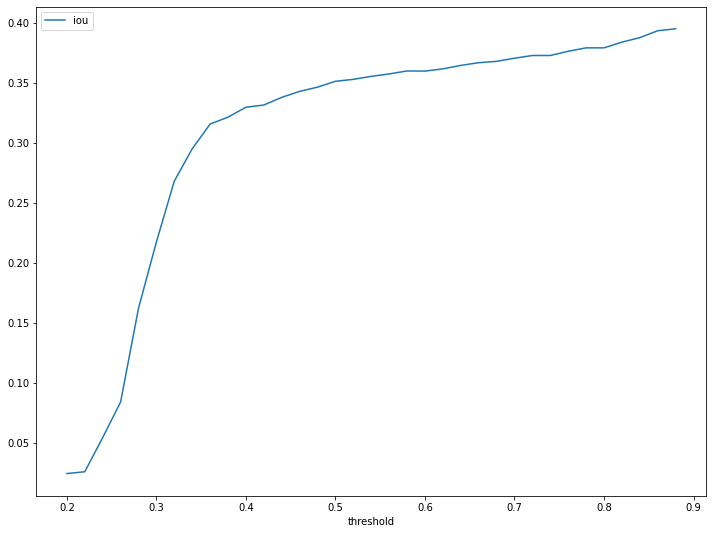

In [28]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

## Conclusions:

- Pretrained models can be used for segmentation problems:
    - Some of architectures can be easily adapted to the problem (ie ResNet)
    - Other architectures may require more experimentation with selection of proper layers for feature extraction and padding (example of using [Xception](https://www.kaggle.com/meaninglesslives/getting-0-87-on-private-lb-using-kaggle-kernel). )
    - You can experiment with selection of layers for feature extraction
    - For some models, you can also try to experiment with number of encoder/decoder blocks
- Threshold optimization is important in problems, where direct metric optimization during training is difficult.
    - It it possible to use more involved optimization methods (from [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)), although this may not be optimal unless distribution of train and test set are very similar. Overoptimization of threshold or any other parameter on validation set may result in worse test set results.
- Experiment with various losses - BCE, Dice, combined BCE with Dice, Lovash loss.
    - Models trained with various losses may give different results, which may be advantageous when ensembling.


### Possible experiments:

- Change type of decoder block in created segmentation model
- Create your own decoder blocks
- Train with other losses
- Train longer
- Train with BCE/Dice, save the model, then load weights and finetune with Lovash loss
- Try different ranges and intervals for threshold optimization

In [29]:
np.int32(0.7 > 1)

0

In [30]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

### 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。


《視点例》  
前回使用した実装とはどのように違うのか  
転移学習をどのように行っているか

層の数　前回は１０（ただのU_n et)　今回　は５０と１９(res_net, vgg)  
活性化関数にPLeruを使っている。（leruより優秀らしい)  
今回は予め学習済みのモデルを使っている  
エポックごとにh5ファイル に学習情報を保存している。  
イメージネットの重みをダウンロードして使っている。  
最後に出てきた予測に対してthreshhold　optimaiziationと言うのをしている  
最適はiouになるように閾値を設定しているようだ。

In [ ]:
"""今回のモデル"""
"""
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           activation_1[0][0]               
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           pool1_pad[0][0]                  
__________________________________________________________________________________________________
res2a_branch2a (Conv2D)         (None, 56, 56, 64)   4160        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
bn2a_branch2a (BatchNormalizati (None, 56, 56, 64)   256         res2a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 56, 56, 64)   0           bn2a_branch2a[0][0]              
__________________________________________________________________________________________________
res2a_branch2b (Conv2D)         (None, 56, 56, 64)   36928       activation_2[0][0]               
__________________________________________________________________________________________________
bn2a_branch2b (BatchNormalizati (None, 56, 56, 64)   256         res2a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 56, 56, 64)   0           bn2a_branch2b[0][0]              
__________________________________________________________________________________________________
res2a_branch2c (Conv2D)         (None, 56, 56, 256)  16640       activation_3[0][0]               
__________________________________________________________________________________________________
res2a_branch1 (Conv2D)          (None, 56, 56, 256)  16640       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
bn2a_branch2c (BatchNormalizati (None, 56, 56, 256)  1024        res2a_branch2c[0][0]             
__________________________________________________________________________________________________
bn2a_branch1 (BatchNormalizatio (None, 56, 56, 256)  1024        res2a_branch1[0][0]              
__________________________________________________________________________________________________
add_1 (Add)                     (None, 56, 56, 256)  0           bn2a_branch2c[0][0]              
                                                                 bn2a_branch1[0][0]               
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 56, 56, 256)  0           add_1[0][0]                      
__________________________________________________________________________________________________
res2b_branch2a (Conv2D)         (None, 56, 56, 64)   16448       activation_4[0][0]               
__________________________________________________________________________________________________
bn2b_branch2a (BatchNormalizati (None, 56, 56, 64)   256         res2b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 56, 56, 64)   0           bn2b_branch2a[0][0]              
__________________________________________________________________________________________________
res2b_branch2b (Conv2D)         (None, 56, 56, 64)   36928       activation_5[0][0]               
__________________________________________________________________________________________________
bn2b_branch2b (BatchNormalizati (None, 56, 56, 64)   256         res2b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 56, 56, 64)   0           bn2b_branch2b[0][0]              
__________________________________________________________________________________________________
res2b_branch2c (Conv2D)         (None, 56, 56, 256)  16640       activation_6[0][0]               
__________________________________________________________________________________________________
bn2b_branch2c (BatchNormalizati (None, 56, 56, 256)  1024        res2b_branch2c[0][0]             
__________________________________________________________________________________________________
add_2 (Add)                     (None, 56, 56, 256)  0           bn2b_branch2c[0][0]              
                                                                 activation_4[0][0]               
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 56, 56, 256)  0           add_2[0][0]                      
__________________________________________________________________________________________________
res2c_branch2a (Conv2D)         (None, 56, 56, 64)   16448       activation_7[0][0]               
__________________________________________________________________________________________________
bn2c_branch2a (BatchNormalizati (None, 56, 56, 64)   256         res2c_branch2a[0][0]             
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 56, 56, 64)   0           bn2c_branch2a[0][0]              
__________________________________________________________________________________________________
res2c_branch2b (Conv2D)         (None, 56, 56, 64)   36928       activation_8[0][0]               
__________________________________________________________________________________________________
bn2c_branch2b (BatchNormalizati (None, 56, 56, 64)   256         res2c_branch2b[0][0]             
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 56, 56, 64)   0           bn2c_branch2b[0][0]              
__________________________________________________________________________________________________
res2c_branch2c (Conv2D)         (None, 56, 56, 256)  16640       activation_9[0][0]               
__________________________________________________________________________________________________
bn2c_branch2c (BatchNormalizati (None, 56, 56, 256)  1024        res2c_branch2c[0][0]             
__________________________________________________________________________________________________
add_3 (Add)                     (None, 56, 56, 256)  0           bn2c_branch2c[0][0]              
                                                                 activation_7[0][0]               
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 56, 56, 256)  0           add_3[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2b[0][0]              
__________________________________________________________________________________________________
res3a_branch2c (Conv2D)         (None, 28, 28, 512)  66048       activation_12[0][0]              
__________________________________________________________________________________________________
res3a_branch1 (Conv2D)          (None, 28, 28, 512)  131584      activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3a_branch2c[0][0]             
__________________________________________________________________________________________________
bn3a_branch1 (BatchNormalizatio (None, 28, 28, 512)  2048        res3a_branch1[0][0]              
__________________________________________________________________________________________________
add_4 (Add)                     (None, 28, 28, 512)  0           bn3a_branch2c[0][0]              
                                                                 bn3a_branch1[0][0]               
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 28, 28, 512)  0           add_4[0][0]                      
__________________________________________________________________________________________________
res3b_branch2a (Conv2D)         (None, 28, 28, 128)  65664       activation_13[0][0]              
__________________________________________________________________________________________________
bn3b_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 28, 28, 128)  0           bn3b_branch2a[0][0]              
__________________________________________________________________________________________________
res3b_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_14[0][0]              
__________________________________________________________________________________________________
bn3b_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 28, 28, 128)  0           bn3b_branch2b[0][0]              
__________________________________________________________________________________________________
res3b_branch2c (Conv2D)         (None, 28, 28, 512)  66048       activation_15[0][0]              
__________________________________________________________________________________________________
bn3b_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3b_branch2c[0][0]             
__________________________________________________________________________________________________
add_5 (Add)                     (None, 28, 28, 512)  0           bn3b_branch2c[0][0]              
                                                                 activation_13[0][0]              
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 28, 28, 512)  0           add_5[0][0]                      
__________________________________________________________________________________________________
res3c_branch2a (Conv2D)         (None, 28, 28, 128)  65664       activation_16[0][0]              
__________________________________________________________________________________________________
bn3c_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3c_branch2a[0][0]             
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 28, 28, 128)  0           bn3c_branch2a[0][0]              
__________________________________________________________________________________________________
res3c_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_17[0][0]              
__________________________________________________________________________________________________
bn3c_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3c_branch2b[0][0]             
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 28, 28, 128)  0           bn3c_branch2b[0][0]              
__________________________________________________________________________________________________
res3c_branch2c (Conv2D)         (None, 28, 28, 512)  66048       activation_18[0][0]              
__________________________________________________________________________________________________
bn3c_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3c_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 28, 28, 512)  0           bn3c_branch2c[0][0]              
                                                                 activation_16[0][0]              
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 28, 28, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res3d_branch2a (Conv2D)         (None, 28, 28, 128)  65664       activation_19[0][0]              
__________________________________________________________________________________________________
bn3d_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3d_branch2a[0][0]             
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 28, 28, 128)  0           bn3d_branch2a[0][0]              
__________________________________________________________________________________________________
res3d_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_20[0][0]              
__________________________________________________________________________________________________
bn3d_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 28, 28, 128)  0           bn3d_branch2b[0][0]              
__________________________________________________________________________________________________
res3d_branch2c (Conv2D)         (None, 28, 28, 512)  66048       activation_21[0][0]              
__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_23[0][0]              
__________________________________________________________________________________________________
bn4a_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 14, 14, 256)  0           bn4a_branch2b[0][0]              
__________________________________________________________________________________________________
res4a_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_24[0][0]              
__________________________________________________________________________________________________
res4a_branch1 (Conv2D)          (None, 14, 14, 1024) 525312      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4a_branch2c[0][0]             
__________________________________________________________________________________________________
bn4a_branch1 (BatchNormalizatio (None, 14, 14, 1024) 4096        res4a_branch1[0][0]              
__________________________________________________________________________________________________
add_8 (Add)                     (None, 14, 14, 1024) 0           bn4a_branch2c[0][0]              
                                                                 bn4a_branch1[0][0]               
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 14, 14, 1024) 0           add_8[0][0]                      
__________________________________________________________________________________________________
res4b_branch2a (Conv2D)         (None, 14, 14, 256)  262400      activation_25[0][0]              
__________________________________________________________________________________________________
bn4b_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 14, 14, 256)  0           bn4b_branch2a[0][0]              
__________________________________________________________________________________________________
res4b_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_26[0][0]              
__________________________________________________________________________________________________
bn4b_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 14, 14, 256)  0           bn4b_branch2b[0][0]              
__________________________________________________________________________________________________
res4b_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_27[0][0]              
__________________________________________________________________________________________________
bn4b_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4b_branch2c[0][0]             
__________________________________________________________________________________________________
add_9 (Add)                     (None, 14, 14, 1024) 0           bn4b_branch2c[0][0]              
                                                                 activation_25[0][0]              
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 14, 14, 1024) 0           add_9[0][0]                      
__________________________________________________________________________________________________
res4c_branch2a (Conv2D)         (None, 14, 14, 256)  262400      activation_28[0][0]              
__________________________________________________________________________________________________
bn4c_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4c_branch2a[0][0]             
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 14, 14, 256)  0           bn4c_branch2a[0][0]              
__________________________________________________________________________________________________
res4c_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_29[0][0]              
__________________________________________________________________________________________________
bn4c_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4c_branch2b[0][0]             
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 14, 14, 256)  0           bn4c_branch2b[0][0]              
__________________________________________________________________________________________________
res4c_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_30[0][0]              
__________________________________________________________________________________________________
bn4c_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4c_branch2c[0][0]             
__________________________________________________________________________________________________
add_10 (Add)                    (None, 14, 14, 1024) 0           bn4c_branch2c[0][0]              
                                                                 activation_28[0][0]              
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 14, 14, 1024) 0           add_10[0][0]                     
__________________________________________________________________________________________________
res4d_branch2a (Conv2D)         (None, 14, 14, 256)  262400      activation_31[0][0]              
__________________________________________________________________________________________________
bn4d_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4d_branch2a[0][0]             
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2a[0][0]              
__________________________________________________________________________________________________
res4d_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_32[0][0]              
__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_31[0][0]              
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 14, 14, 1024) 0           add_11[0][0]                     
__________________________________________________________________________________________________
res4e_branch2a (Conv2D)         (None, 14, 14, 256)  262400      activation_34[0][0]              
__________________________________________________________________________________________________
bn4e_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4e_branch2a[0][0]             
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 14, 14, 256)  0           bn4e_branch2a[0][0]              
__________________________________________________________________________________________________
res4e_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_35[0][0]              
__________________________________________________________________________________________________
bn4e_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4e_branch2b[0][0]             
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 14, 14, 256)  0           bn4e_branch2b[0][0]              
__________________________________________________________________________________________________
res4e_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_36[0][0]              
__________________________________________________________________________________________________
bn4e_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4e_branch2c[0][0]             
__________________________________________________________________________________________________
add_12 (Add)                    (None, 14, 14, 1024) 0           bn4e_branch2c[0][0]              
                                                                 activation_34[0][0]              
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 14, 14, 1024) 0           add_12[0][0]                     
__________________________________________________________________________________________________
res4f_branch2a (Conv2D)         (None, 14, 14, 256)  262400      activation_37[0][0]              
__________________________________________________________________________________________________
bn4f_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4f_branch2a[0][0]             
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 14, 14, 256)  0           bn4f_branch2a[0][0]              
__________________________________________________________________________________________________
res4f_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_38[0][0]              
__________________________________________________________________________________________________
bn4f_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4f_branch2b[0][0]             
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 14, 14, 256)  0           bn4f_branch2b[0][0]              
__________________________________________________________________________________________________
res4f_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_39[0][0]              
__________________________________________________________________________________________________
bn4f_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4f_branch2c[0][0]             
__________________________________________________________________________________________________
add_13 (Add)                    (None, 14, 14, 1024) 0           bn4f_branch2c[0][0]              
                                                                 activation_37[0][0]              
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 14, 14, 1024) 0           add_13[0][0]                     
__________________________________________________________________________________________________
res5a_branch2a (Conv2D)         (None, 7, 7, 512)    524800      activation_40[0][0]              
__________________________________________________________________________________________________
bn5a_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 7, 7, 512)    0           bn5a_branch2a[0][0]              
__________________________________________________________________________________________________
res5a_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_41[0][0]              
__________________________________________________________________________________________________
bn5a_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 7, 7, 512)    0           bn5a_branch2b[0][0]              
__________________________________________________________________________________________________
res5a_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_42[0][0]              
__________________________________________________________________________________________________
res5a_branch1 (Conv2D)          (None, 7, 7, 2048)   2099200     activation_40[0][0]              
__________________________________________________________________________________________________
bn5a_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5a_branch2c[0][0]             
__________________________________________________________________________________________________
bn5a_branch1 (BatchNormalizatio (None, 7, 7, 2048)   8192        res5a_branch1[0][0]              
__________________________________________________________________________________________________
add_14 (Add)                    (None, 7, 7, 2048)   0           bn5a_branch2c[0][0]              
                                                                 bn5a_branch1[0][0]               
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 7, 7, 2048)   0           add_14[0][0]                     
__________________________________________________________________________________________________
res5b_branch2a (Conv2D)         (None, 7, 7, 512)    1049088     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_45[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5b_branch2c[0][0]             
__________________________________________________________________________________________________
add_15 (Add)                    (None, 7, 7, 2048)   0           bn5b_branch2c[0][0]              
                                                                 activation_43[0][0]              
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 7, 7, 2048)   0           add_15[0][0]                     
__________________________________________________________________________________________________
res5c_branch2a (Conv2D)         (None, 7, 7, 512)    1049088     activation_46[0][0]              
__________________________________________________________________________________________________
bn5c_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5c_branch2a[0][0]             
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 7, 7, 512)    0           bn5c_branch2a[0][0]              
__________________________________________________________________________________________________
res5c_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_47[0][0]              
__________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5c_branch2b[0][0]             
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 7, 7, 512)    0           bn5c_branch2b[0][0]              
__________________________________________________________________________________________________
res5c_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_48[0][0]              
__________________________________________________________________________________________________
bn5c_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5c_branch2c[0][0]             
__________________________________________________________________________________________________
add_16 (Add)                    (None, 7, 7, 2048)   0           bn5c_branch2c[0][0]              
                                                                 activation_46[0][0]              
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 7, 7, 2048)   0           add_16[0][0]                     
__________________________________________________________________________________________________
center_conv (Conv2D)            (None, 7, 7, 512)    9437696     activation_49[0][0]              
__________________________________________________________________________________________________
center_bn (BatchNormalization)  (None, 7, 7, 512)    2048        center_conv[0][0]                
__________________________________________________________________________________________________
center_activation (PReLU)       (None, 7, 7, 512)    25088       center_bn[0][0]                  
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 7, 7, 2560)   0           center_activation[0][0]          
                                                                 activation_49[0][0]              
__________________________________________________________________________________________________
decoder4_conv (Conv2D)          (None, 7, 7, 256)    5898496     concatenate_1[0][0]              
__________________________________________________________________________________________________
decoder4_bn (BatchNormalization (None, 7, 7, 256)    1024        decoder4_conv[0][0]              
__________________________________________________________________________________________________
decoder4_activation (PReLU)     (None, 7, 7, 256)    12544       decoder4_bn[0][0]                
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 14, 14, 256)  0           decoder4_activation[0][0]        
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 14, 14, 1280) 0           up_sampling2d_1[0][0]            
                                                                 activation_40[0][0]              
__________________________________________________________________________________________________
decoder3_conv (Conv2D)          (None, 14, 14, 128)  1474688     concatenate_2[0][0]              
__________________________________________________________________________________________________
decoder3_bn (BatchNormalization (None, 14, 14, 128)  512         decoder3_conv[0][0]              
__________________________________________________________________________________________________
decoder3_activation (PReLU)     (None, 14, 14, 128)  25088       decoder3_bn[0][0]                
__________________________________________________________________________________________________
up_sampling2d_2 (UpSampling2D)  (None, 28, 28, 128)  0           decoder3_activation[0][0]        
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 28, 28, 640)  0           up_sampling2d_2[0][0]            
                                                                 activation_22[0][0]              
__________________________________________________________________________________________________
decoder2_conv (Conv2D)          (None, 28, 28, 64)   368704      concatenate_3[0][0]              
__________________________________________________________________________________________________
decoder2_bn (BatchNormalization (None, 28, 28, 64)   256         decoder2_conv[0][0]              
__________________________________________________________________________________________________
decoder2_activation (PReLU)     (None, 28, 28, 64)   50176       decoder2_bn[0][0]                
__________________________________________________________________________________________________
up_sampling2d_3 (UpSampling2D)  (None, 56, 56, 64)   0           decoder2_activation[0][0]        
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 56, 56, 320)  0           up_sampling2d_3[0][0]            
                                                                 activation_10[0][0]              
__________________________________________________________________________________________________
decoder1_conv (Conv2D)          (None, 56, 56, 64)   184384      concatenate_4[0][0]              
__________________________________________________________________________________________________
decoder1_bn (BatchNormalization (None, 56, 56, 64)   256         decoder1_conv[0][0]              
__________________________________________________________________________________________________
decoder1_activation (PReLU)     (None, 56, 56, 64)   200704      decoder1_bn[0][0]                
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 112, 112, 64) 0           decoder1_activation[0][0]        
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 112, 112, 128 0           up_sampling2d_4[0][0]            
                                                                 activation_1[0][0]               
__________________________________________________________________________________________________
up_sampling2d_5 (UpSampling2D)  (None, 224, 224, 128 0           concatenate_5[0][0]              
__________________________________________________________________________________________________
decoder_output_conv (Conv2D)    (None, 224, 224, 32) 36896       up_sampling2d_5[0][0]            
__________________________________________________________________________________________________
decoder_output_bn (BatchNormali (None, 224, 224, 32) 128         decoder_output_conv[0][0]        
__________________________________________________________________________________________________
decoder_output_activation (PReL (None, 224, 224, 32) 1605632     decoder_output_bn[0][0]          
__________________________________________________________________________________________________
prediction (Conv2D)             (None, 224, 224, 1)  33          decoder_output_activation[0][0]  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 224, 224, 1)  0           prediction[0][0]                 
================================================================================================

"""

In [34]:
from keras.applications.vgg19 import VGG19, preprocess_input

In [35]:
# unet_vgg19
def unet_vgg19(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = VGG19(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # 最後はpoolで調整？
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block2_conv1').output
    encoder2 = base_model.get_layer('block3_conv1').output
    encoder3 = base_model.get_layer('block4_conv1').output
    encoder4 = base_model.get_layer('block5_conv1').output
    encoder5 = base_model.get_layer('block5_pool').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [36]:

input_size = (224, 224, 3)

K.clear_session()
model = unet_vgg19(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

80142336/80134624 [==============================] - 95s 1us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________

# VGG

In [37]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
model_depth = unet_vgg19(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 2  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 21142s 7s/step - loss: 0.8766 - my_iou_metric: 0.1625 - val_loss: 2.6078 - val_my_iou_metric: 0.1681

Epoch 00001: val_my_iou_metric improved from -inf to 0.16812, saving model to unet_resnet.h5
Epoch 2/2
 160/3200 [>.............................] - ETA: 7:42:42 - loss: 0.8068 - my_iou_metric: 0.2631

KeyboardInterrupt: 

### 以降省略、最終的には以下の出力になります。

In [13]:
import matplotlib.pyplot as plt

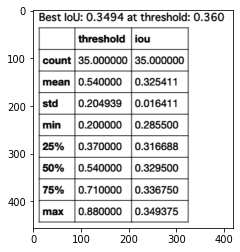

In [18]:
img = plt.imread('iou_thresh_list.png')
plt.imshow(img)

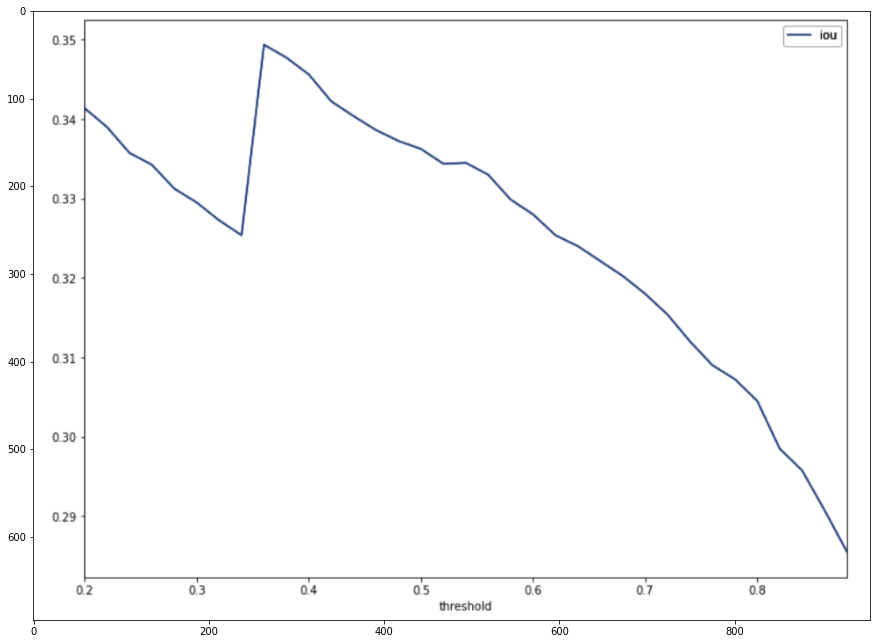

In [36]:
img = plt.imread('iou_thresh_graph.png')
plt.figure(figsize = (15,20))
plt.imshow(img)

### res_netとの比較

In [27]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.3949 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.310279
std,0.204939,0.107305
min,0.200000,0.024250
25%,0.370000,0.318375
50%,0.540000,0.355250
75%,0.710000,0.371500
max,0.880000,0.394875


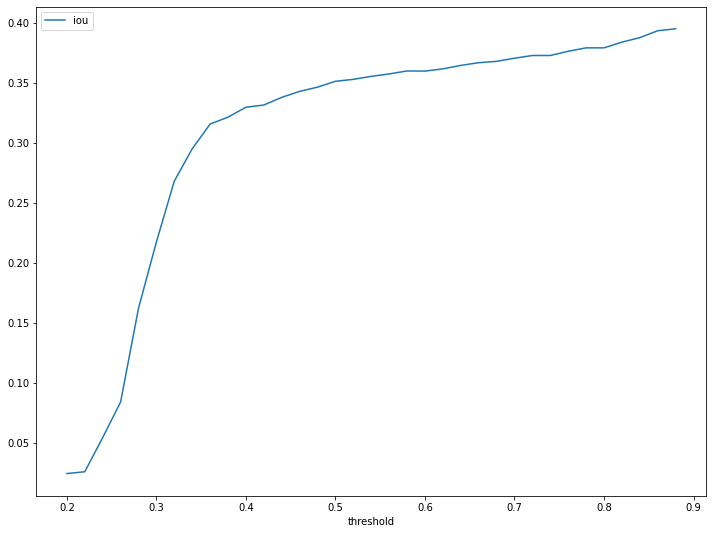

In [28]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

### res_netの方がvggに比べてiouが大きいため適していると思われる。